In [1]:
from river import stream
from river.datasets import base

class SolarFlare(base.FileDataset):
    def __init__(self):
        super().__init__(
            n_samples=1066,
            n_features=10,
            n_outputs=1,
            task=base.MO_REG,
            filename="solar-flare.csv.zip",
        )
    
    def __iter__(self):
        return stream.iter_csv(
            self.path,
            target="m-class-flares",
            converters={
                "zurich-class": str,
                "largest-spot-size": str,
                "spot-distribution": str,
                "activity": int,
                "evolution": int,
                "previous-24h-flare-activity": int,
                "hist-complex": int,
                "hist-complex-this-pass": int,
                "area": int,
                "largest-spot-area": int,
                "c-class-flares": int,
                "m-class-flares": int,
                "x-class-flares": int,
            },
        )

In [3]:
from pprint import pprint
from river import datasets

for x,y in SolarFlare():
    pprint(x)
    pprint(y)
    break

{'activity': 1,
 'area': 1,
 'c-class-flares': 0,
 'evolution': 3,
 'hist-complex': 1,
 'hist-complex-this-pass': 1,
 'largest-spot-area': 1,
 'largest-spot-size': 'A',
 'previous-24h-flare-activity': 1,
 'spot-distribution': 'X',
 'x-class-flares': 0,
 'zurich-class': 'H'}
0


In [9]:
import numbers
from river import compose
from river import datasets
from river import evaluate
from river import linear_model
from river import metrics
from river import preprocessing
from river import tree

num = compose.SelectType(numbers.Number) | preprocessing.MinMaxScaler()
cat = compose.SelectType(str) | preprocessing.OneHotEncoder(sparse=False)
model = tree.HoeffdingTreeRegressor()
pipeline = (num+cat) | model

In [10]:
metric = metrics.MAE()
evaluate.progressive_val_score(SolarFlare(), pipeline, metric)

MAE: 0.096979

In [11]:
errors = []
for x, y in SolarFlare():
    y_pred =pipeline.predict_one(x)
    metric = metric.update(y, y_pred)
    errors.append(metric.get())
    pipeline = pipeline.learn_one(x, y)

Text(0, 0.5, 'MAE')

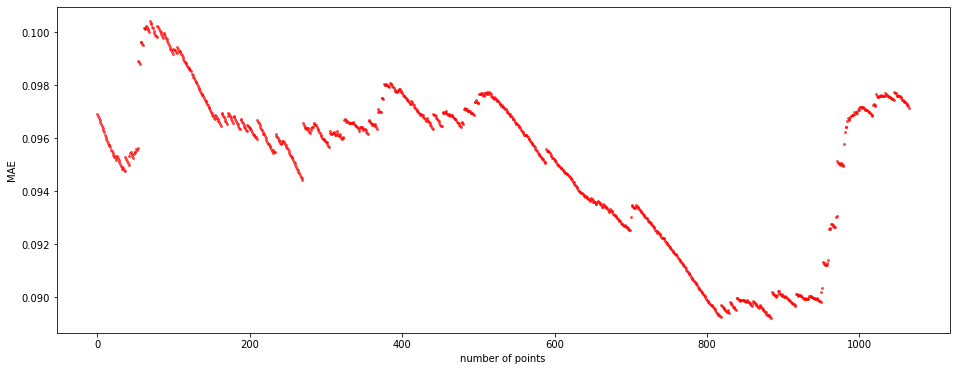

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(
    errors,
    "ro",
    alpha=0.6,
    markersize=2,
    linewidth=4,
)
ax.set_xlabel("number of points")
ax.set_ylabel("MAE")

In [15]:
from river import (
    synth, ensemble, tree,
    evaluate, metrics
)

models = [
    tree.HoeffdingTreeRegressor(),
    tree.HoeffdingAdaptiveTreeRegressor(),
    ensemble.AdaptiveRandomForestRegressor(seed=42)
]

In [20]:
results = {}
for model in models:
    metric = metrics.MSE()
    dataset = synth.ConceptDriftStream(
        seed=42, position=500, width=40
    ).take(1000)
    evaluate.progressive_val_score(dataset, model, metric)
    print(f"{str(model.__class__).split('.')[-1][:-2]}: {metric.get():e}")
    
    for i, (x, y) in enumerate(dataset):
        y_pred = model.predict_one(x)
        metric = metric.update(y, y_pred)
        model = model.learn_one(x, y)
        if (i % 100) == 0:
            errors.append(dict(step=i, error=metric.get()))
            
    results[str(model.__class__).split(".")[-1][:-2]] = errors

HoeffdingTreeRegressor: 8.834257e+42
HoeffdingAdaptiveTreeRegressor: 8.622805e+42
AdaptiveRandomForestRegressor: 1.641288e+42


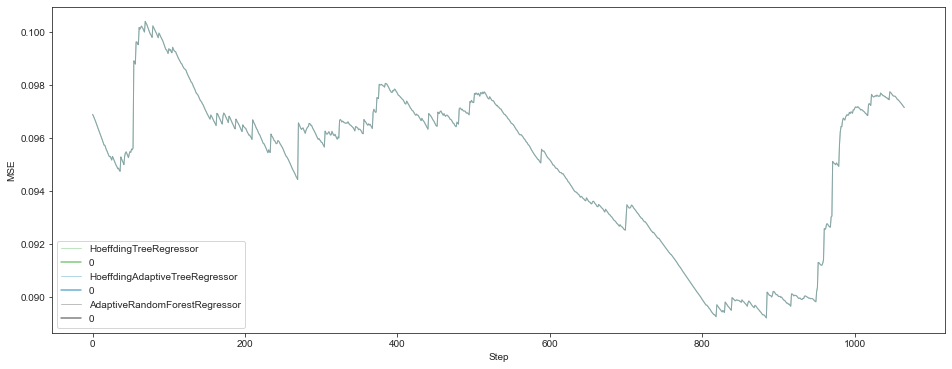

In [30]:
import pandas as pd
import seaborn as sns

plt.figure(figsize=(16, 6))
styles = ["-","--","-.",":"]
#markers = [
#    1, 2, 3
#]

palettes=['Accent', 'Blues', 'gray']

for i, (model, errors) in enumerate(results.items()):
    df = pd.DataFrame(errors)
    sns.lineplot(
        data=df,
        #x="step",
        #y="error",
        linestyle=styles[i%len(styles)],
        alpha=0.5,
        markersize=22,
        palette=palettes[i],
        #markers=markers[i%len(markers)],        
        label=model,
        linewidth=1
    )
    
plt.ylabel("MSE")
plt.xlabel("Step")
sns.set_style("ticks")